# Libraries

In [3]:
import numpy as np # for data manipulation
import pandas as pd # for numeric operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX  # for SARIMAX model
from statsmodels.tsa.stattools import adfuller          # for stationarity test (ADF)
from statsmodels.tools.eval_measures import rmse        # for forecast error evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence \
import variance_inflation_factor as VIF
from statsmodels.tsa.stattools import grangercausalitytests

# Data

Data from 1974-2024 across x teams 

No regularization need for time series models as they assume that:
1. The data is in its original scale (so it can detect trends and patterns).
2. Residuals and variance are meaningful in raw terms.

Distorting the data distorts the results and makes interpretation meaninglesss.

In [4]:
# Loading our data frame
df = pd.read_csv('data/BaseballData590.csv', na_values=['?'])
# Visualizing a summary of the df
df = df.rename(columns={'WL%': 'WinPct'})
df.head()

,Season,Team,Lg,W,GP,L,WinPct,Bat#,PA,AB,...,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/BB
0,2001,SEA,AL,116,162,46,0.716,32,6474,5680,...,40,6096,117,4.12,1.200,7.9,1.0,2.9,6.5,2.26
1,1998,NYY,AL,114,162,48,0.704,32,6444,5643,...,37,6100,116,4.15,1.251,8.4,1.0,2.9,6.7,2.32
2,2022,LAD,NL,111,162,51,0.685,29,6247,5526,...,38,5865,145,3.45,1.048,6.9,0.9,2.5,9.1,3.60
3,2018,BOS,AL,108,162,54,0.667,40,6302,5623,...,51,6166,118,3.82,1.246,8.1,1.1,3.2,9.6,3.04
4,1986,NYM,NL,108,162,54,0.667,36,6349,5558,...,40,6165,115,3.31,1.221,7.9,0.6,3.1,6.6,2.13


# Time Series

## SARIMAX

Seasonal AutoRegressive Integrated Moving Average with Exogenous varibales is an advanced verison of ARIMA that:
- Models trends and seasonality in time series data, in this case win percentage over seasons.
- Adds the ability to include external predictors (exogenous variables), like ERA, OPS, WHIP, etc.

Better than AR and ARIMA as it handle seasonality and uses predictors: better than SARIMA becuase it uses predictors.

Our Goal: Predict each team's win precentage for next yeat, based on:
- the team's own historical win percentages.
- the team's own historical stats.

Give x, y, z stats and past win %, what should we expect Team m's win % to be next year?


Methodology:

1. Choose a Team and filter the datafram to just that one team.

2. Choose a Win Percenatge as the target variable, and stats as predictors.

3. Check for Stationary; Time series models assume taht data doesn't change its behavior over time, i.e. it's stationary. If it's not statioanry, we "difference" the data (substract previous value from current one.)

4. Fit the Sarimax Model using statsmodel package.

5. Forecast and Evaluate.

Limitations:
- SARIMAX's design only allows for one model per team.
- We have to use only past stats to predict future by always shifting the exogenous variables to prevent leakage form future data.
- We have to eb careful with seasonality.
- In case of Missing values in the exogenous varaibles, we need to drop or interpolate.

In [5]:
team_names = df['Team'].unique()
num_teams = len(team_names)
print(f"There are {num_teams} unique teams:")
print(sorted(team_names))

There are 35 unique teams:
['ANA', 'ARI', 'ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'COL', 'DET', 'FLA', 'HOU', 'KCR', 'LAA', 'LAD', 'MIA', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TBD', 'TBR', 'TEX', 'TOR', 'WSN']


In [6]:
# Grouping and listing teams per season
teams_by_year = df.sort_values('Season').groupby('Season')['Team'].unique()

for year, teams in teams_by_year.items():
    print(f"{year}: {sorted(teams)}")


1974: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SFG', 'STL', 'TEX']
1975: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SFG', 'STL', 'TEX']
1976: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SFG', 'STL', 'TEX']
1977: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TEX', 'TOR']
1978: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL', 'MIN', 'MON', 'NYM', 'NYY', 'OAK', 'PHI', 'PIT', 'SDP', 'SEA', 'SFG', 'STL', 'TEX', 'TOR']
1979: ['ATL', 'BAL', 'BOS', 'CAL', 'CHC', 'CHW', 'CIN', 'CLE', 'DET', 'HOU', 'KCR', 'LAD', 'MIL',

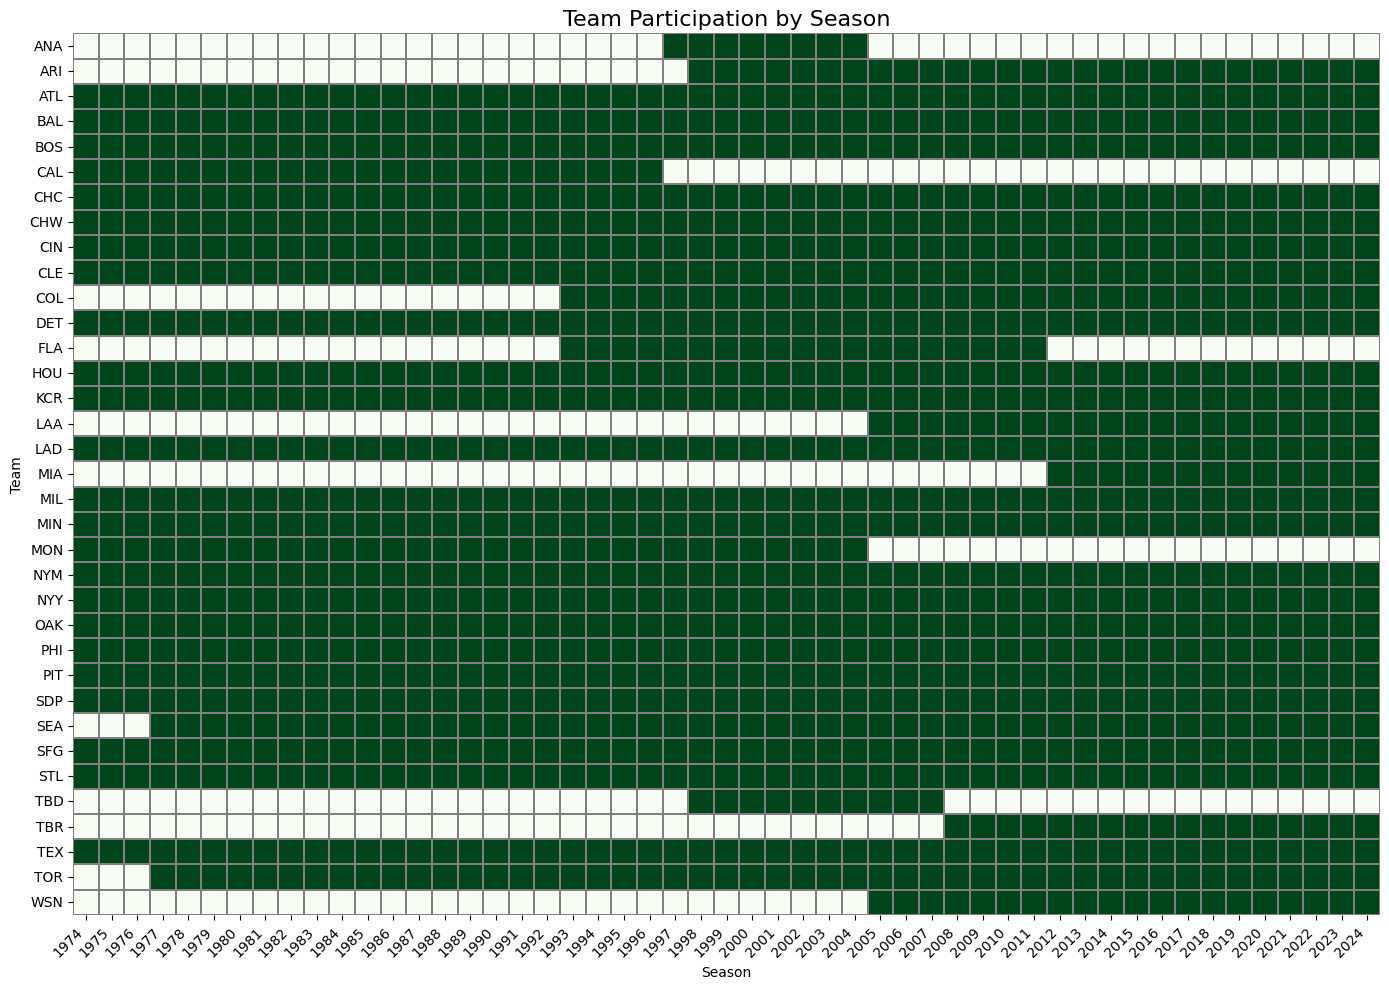

In [7]:
# 1. Create a pivot table of Team x Season
team_year_matrix = (
    df[['Season', 'Team']]
    .drop_duplicates()
    .assign(value=1)
    .pivot(index='Team', columns='Season', values='value')
    .fillna(0)
)

# 2. Sort rows alphabetically, and columns chronologically
team_year_matrix = team_year_matrix.sort_index().sort_index(axis=1)

# 3. Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(team_year_matrix, cmap='Greens', cbar=False, linewidths=0.2, linecolor='gray')

plt.title("Team Participation by Season", fontsize=16)
plt.xlabel("Season")
plt.ylabel("Team")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Team Name Standardization

To accurately model each MLB team’s win percentage over time, we need consistent team identifiers across seasons. However, several franchises have changed names or locations over the years (e.g., Montreal Expos became the Washington Nationals in 2005).

If we don’t account for these changes, the time series for a single franchise gets split across multiple team codes, which breaks historical continuity and weakens our forecasting models.

To fix this, we standardize team names by merging old identifiers into their current franchise names. This allows us to build cleaner, uninterrupted time series models per team.

This step ensures that models like SARIMAX, which rely on consistent time series data, are trained on the full historical performance of each franchise. It also prevents data leakage or artificial gaps in the record that could distort trend detection or forecasting accuracy.




| Historical Code | New Standard | Explanation |
|------------------|--------------|-------------|
| **MON**          | **WSN**      | The Montreal Expos became the Washington Nationals in 2005 |
| **FLA**          | **MIA**      | The Florida Marlins rebranded as the Miami Marlins in 2012 |
| **ANA**          | **LAA**      | The Anaheim Angels became the Los Angeles Angels in 2005 |
| **CAL**          | **LAA**      | The California Angels were an earlier name for the same franchise |
| **TBD**          | **TBR**      | The Tampa Bay Devil Rays rebranded as the Tampa Bay Rays in 2008 |


In [8]:
df['Team'] = df['Team'].replace({
    'MON': 'WSN',
    'ANA': 'LAA',
    'FLA': 'MIA',
    'TBD': 'TBR',
    'CAL': 'LAA'
})


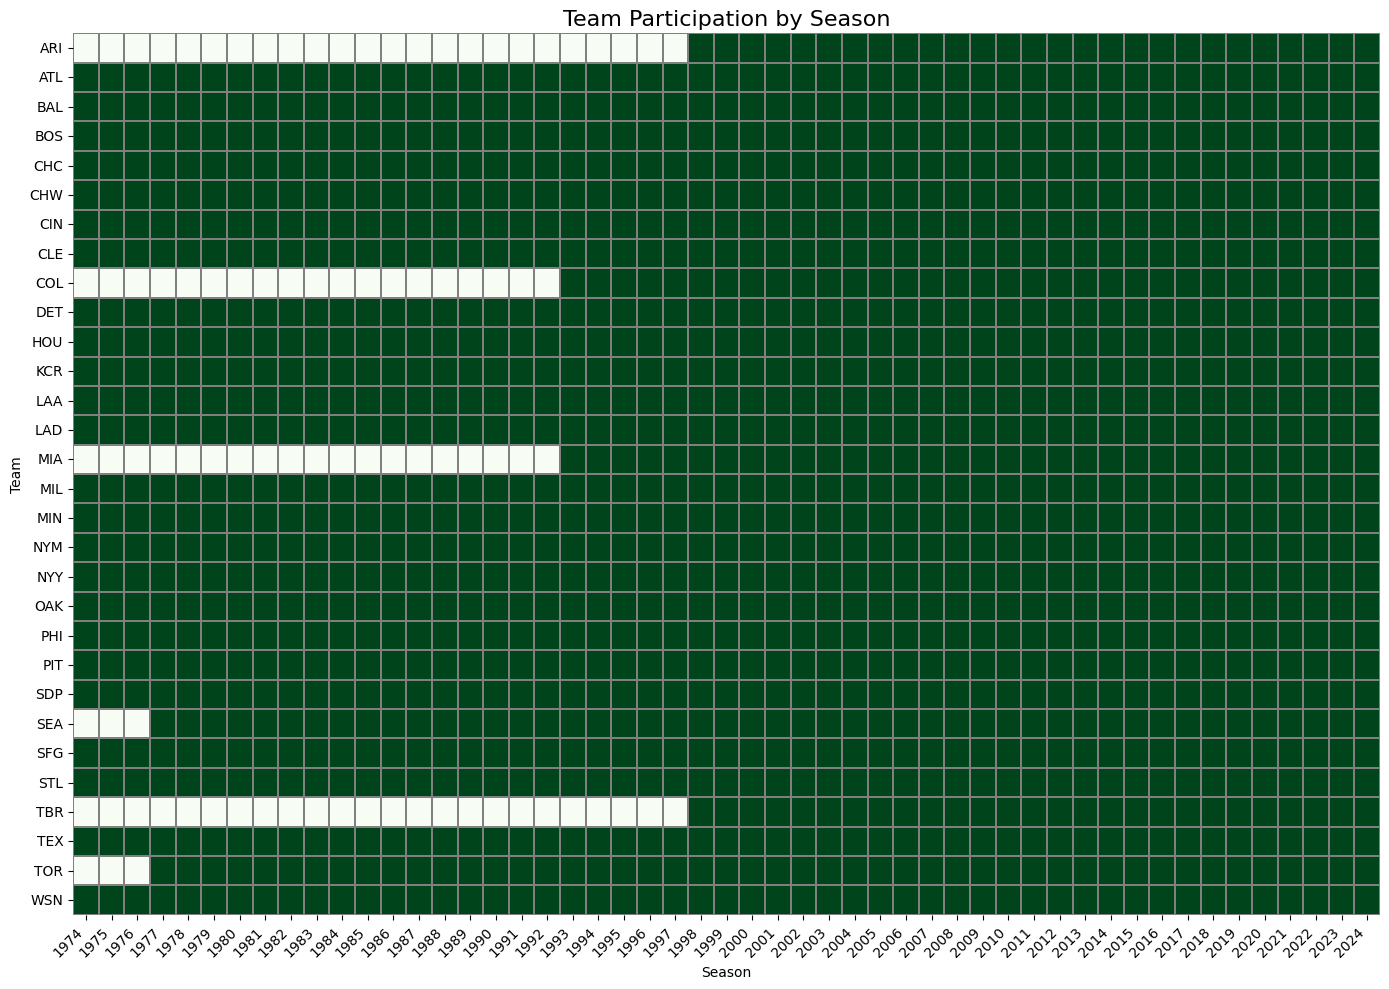

In [9]:
team_year_matrix = (
    df[['Season', 'Team']]
    .drop_duplicates()
    .assign(value=1)
    .pivot(index='Team', columns='Season', values='value')
    .fillna(0)
)

# 2. Sort rows alphabetically, and columns chronologically
team_year_matrix = team_year_matrix.sort_index().sort_index(axis=1)

# 3. Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(team_year_matrix, cmap='Greens', cbar=False, linewidths=0.2, linecolor='gray')

plt.title("Team Participation by Season", fontsize=16)
plt.xlabel("Season")
plt.ylabel("Team")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## First SARIMAX model 

We start building a SARIMAX model for the Yankees, so we extract the data specific team. We choose to build our intiial model with only two predictors that are strong summary stats for team performance: Earned Run Average (ERA), which measures the quality of pitching, and On-base Plus Slugging (OPS) which measures the equality of batting Together ( they summarize how weall a team both prevents and produces runs).

We'll add complexity to the model later on.

### Step 1: Preparing Yankee Time Series Data

In [10]:
# Filtering just the Yankees and sorting by season
yankees_df = df[df['Team'] == 'NYY'].sort_values('Season').reset_index(drop =  True)

# Select key columns: target (WinPct) and two predictors (e.g. ERA, OPS)
cols_to_use = ['Season', 'WinPct', 'ERA', 'OPS']
yankees_df = yankees_df[cols_to_use].dropna()

# Shift predictors one year back so we only use past data to predict next season
yankees_df['ERA_lag'] = yankees_df['ERA'].shift(1)
yankees_df['OPS_lag'] = yankees_df['OPS'].shift(1)

# Drop the first row (which now has NaNs in lagged predictors)
yankees_df = yankees_df.dropna().reset_index(drop=True)

# Preview the cleaned dataset
print(yankees_df.head())

   Season  WinPct   ERA    OPS  ERA_lag  OPS_lag
0    1975   0.519  3.29  0.707     3.32    0.692
1    1976   0.610  3.19  0.716     3.29    0.707
2    1977   0.617  3.63  0.788     3.19    0.716
3    1978   0.613  3.18  0.718     3.63    0.788
4    1979   0.556  3.85  0.733     3.18    0.718


In order to accurately forecast a team’s win percentage for a given season, we need to ensure that the model only uses information that would have been available before the season began. This avoids data leakage, where future information accidentally influences past predictions.

To achieve this, we shifted all predictor variables (e.g., ERA, OPS) back by one year. This means that for any given season, the model is using the previous year’s stats as inputs.

For example, to predict the Yankees’ win percentage in 2000, the model uses: ERA and OPS from 1999

This creates a more realistic modeling framework where forecasts are made using only historical data, as would be the case in an actual forward-looking scenario.

### Step 2. Checking for Stationarity

SARIMAX assumes teh target variable (Win %) is stationary, meaning it has a constant mean and variance over time, and it has no lon-term upward/downward trends.

We use the Augmented Dickey-Fuller (ADF) test to check.

In [11]:
# Run the ADF test on the WinPct series
result = adfuller(yankees_df['WinPct'])

# Print the test statistic and p-value
print("ADF Test Statistic:", result[0])
if result[1] < 0.05:
    print("our p-value:", result[1], "is less than 0.05")
else:
    print("our p-value:", result[1], "is greater than 0.05")



ADF Test Statistic: -3.9706352720852878
our p-value: 0.0015723244592452962 is less than 0.05


In [ ]:
# Run the ADF test on the WinPct series
result = adfuller(yankees_df['WinPct'])

# Print the test statistic and p-value
print("ADF Test Statistic:", result[0])
if result[1] < 0.05:
    print("our p-value:", result[1], "is less than 0.05")
else:
    print("our p-value:", result[1], "is greater than 0.05")



ADF Test Statistic: -3.9706352720852878
our p-value: 0.0015723244592452962 is less than 0.05


We observe that the p-value is much less than 0.05, meaning that our win % series is stationary, and there is no differencing needed.

### Step 3. Fit the SARIMAX model

(p, d, q) are the core parameters that define how the time series model will handle patters in the Win %.

| Parameter | Name                      | What It Does                                                                 |
|-----------|---------------------------|------------------------------------------------------------------------------|
| **p**     | Autoregressive (AR) term  | Uses lagged values of the target variable (e.g., last season’s WinPct)      |
| **d**     | Differencing              | Removes trends in the data by differencing (set to 0 if stationary)         |
| **q**     | Moving Average (MA) term  | Uses lagged forecast errors to improve accuracy                             |

**Example:** SARIMAX(1, 0, 1)  
- `p = 1`: use last year's WinPct  
- `d = 0`: no differencing needed (our data is stationary)  
- `q = 1`: adjust based on last year’s prediction error

In [12]:
order = (1, 0, 1)  # AR(1), no differencing, MA(1)


To begin modeling, we use (p, d, q) = (1, 0, 1) as a baseline configuration for the SARIMAX model.

p = 1 (Autoregressive term): This allows the model to consider the previous season’s win percentage, capturing momentum or persistence in performance.

d = 0 (Differencing): Since our target variable WinPct is already stationary (confirmed via ADF test), no differencing is needed.

q = 1 (Moving Average term): This accounts for the error from the previous forecast, helping smooth out unexpected shocks or fluctuations.

This configuration is a standard starting point because it captures essential time series dynamics without overfitting. Once the model is tested, we can refine these values using model diagnostics (like AIC/BIC) or automated selection tools

In [13]:
# Define the target and exogenous variables
y = yankees_df['WinPct']
X = yankees_df[['ERA_lag', 'OPS_lag']]

# Define and fit the SARIMAX model
model = SARIMAX(endog=y, exog=X, order=(1, 0, 1))
results = model.fit()

# Print the summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 WinPct   No. Observations:                   50
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  81.309
Date:                Mon, 21 Apr 2025   AIC                           -152.618
Time:                        22:21:35   BIC                           -143.058
Sample:                             0   HQIC                          -148.977
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ERA_lag       -0.0624      0.020     -3.133      0.002      -0.101      -0.023
OPS_lag        1.0688      0.104     10.286      0.000       0.865       1.272
ar.L1          0.2767      0.449      0.617      0.5

We fit a SARIMAX(1, 0, 1) model to predict the Yankees’ win percentage (WinPct) using two lagged predictors: ERA and OPS from the previous season.

Key Findings:

ERA_lag has a significant negative effect (p = 0.002), indicating that lower ERA in the previous season is associated with higher win percentage in the following season.

OPS_lag has a strong positive and significant effect (p < 0.001), meaning that better offensive performance (higher OPS) last year leads to more wins this year.

The AR(1) and MA(1) terms were not statistically significant, suggesting that win percentage does not strongly depend on its own previous value or forecast error in this case.

Diagnostic tests indicate that the residuals are well-behaved (no autocorrelation, approximate normality), and the model fits the data well.

### Testing the model

We built a SARIMAX(1, 0, 1) model to forecast the New York Yankees’ win percentage using lagged team statistics: ERA and OPS from the previous season. To evaluate real-world performance, we trained the model on seasons prior to 2015 and tested it on the seasons from 2015 to 2024.

Test RMSE: 0.0522
Test MAE: 0.0466


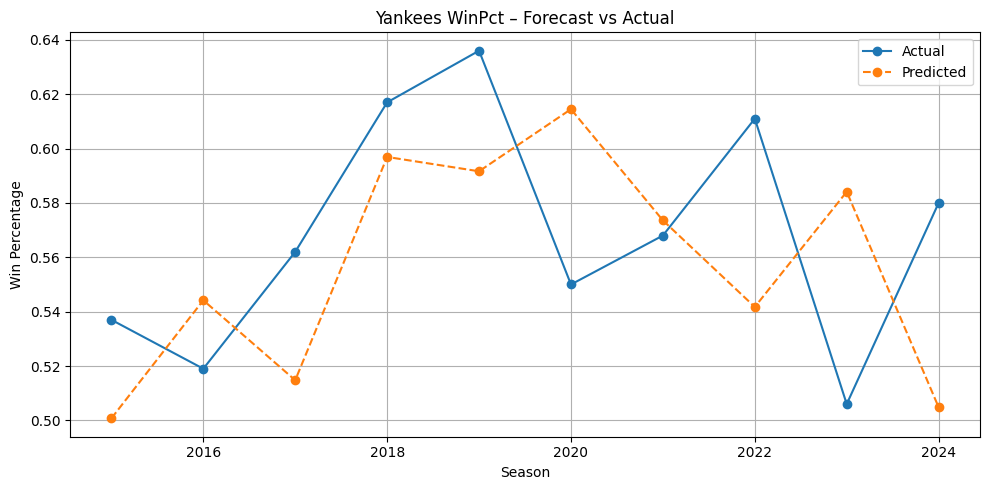

In [14]:
# Step 1: Create 75-25 train/test split (e.g., train = before 2015, test = 2015 and later)
train = yankees_df[yankees_df['Season'] < 2015]
test = yankees_df[yankees_df['Season'] >= 2015]

# Step 2: Define target and predictors
y_train = train['WinPct']
X_train = train[['ERA_lag', 'OPS_lag']]
y_test = test['WinPct']
X_test = test[['ERA_lag', 'OPS_lag']]

# Step 3: Fit SARIMAX model on training data
model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1))
results = model.fit()

# Step 4: Forecast on test period
start = test.index[0]
end = test.index[-1]
pred = results.predict(start=start, end=end, exog=X_test)

# Step 5: Evaluate performance
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)

print("Test RMSE:", round(rmse, 4))
print("Test MAE:", round(mae, 4))

# Step 6: Plot predictions vs actual
plt.figure(figsize=(10,5))
plt.plot(test['Season'], y_test, marker='o', label='Actual')
plt.plot(test['Season'], pred, marker='o', linestyle='--', label='Predicted')
plt.title("Yankees WinPct – Forecast vs Actual")
plt.xlabel("Season")
plt.ylabel("Win Percentage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Our results show:

- Test RMSE: 0.0522

- Test MAE: 0.0466

The model captured overall trends in team performance and made reasonably accurate out-of-sample predictions.

Both ERA_lag and OPS_lag were statistically significant predictors, confirming that a team's previous pitching and batting performance help explain next season’s success.

This provides a strong foundation for team-level forecasting and can be expanded with additional predictors or adapted for other teams.


## Generalizing our model

We use Python’s try / except structure to handle potential errors that can occur when fitting a SARIMAX model for each team. Some teams may have missing data, short histories, or convergence issues that cause the model to fail. Without error handling, one failed model would crash the entire loop.

Using try / except allows the loop to continue running and simply skip teams that raise an error, while printing a helpful message for debugging. This makes the modeling process more robust and scalable.

In [15]:
# Initiliaze results
results = []

# Looping through each team
for team in df['Team'].unique():
    team_df = df[df['Team'] == team].sort_values('Season').reset_index(drop=True)
    
    # Skip if missing values for predictors
    if team_df[['WinPct', 'ERA', 'OPS']].isnull().any().any():
        continue

    # Create lagged predictors
    team_df['ERA_lag'] = team_df['ERA'].shift(1)
    team_df['OPS_lag'] = team_df['OPS'].shift(1)
    team_df = team_df.dropna().reset_index(drop=True)

    # Train/test split
    train = team_df[team_df['Season'] < 2015]
    test = team_df[team_df['Season'] >= 2015]

    # Skip if not enough test data
    if len(test) < 2 or len(train) < 10:
        continue

    y_train = train['WinPct']
    X_train = train[['ERA_lag', 'OPS_lag']]
    y_test = test['WinPct']
    X_test = test[['ERA_lag', 'OPS_lag']]

    try:
        # Fit SARIMAX model
        model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1))
        model_fit = model.fit(disp=False)

        # Predict on test set
        pred = model_fit.predict(start=test.index[0], end=test.index[-1], exog=X_test)

        # Calculate errors
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)

        # Store results
        results.append({
            'Team': team,
            'Test RMSE': round(rmse, 4),
            'Test MAE': round(mae, 4),
            'Train Size': len(train),
            'Test Size': len(test)
        })

    except Exception as e:
        print(f"Model failed for {team}: {e}")

# STEP 4: Create a results dataframe
results_df1 = pd.DataFrame(results).sort_values('Test RMSE')

# Display
results_df1.reset_index(drop=True, inplace=True)
results_df1

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramet

,Team,Test RMSE,Test MAE,Train Size,Test Size
0,PHI,0.0356,0.0310,40,10
1,LAA,0.0443,0.0335,40,10
2,NYY,0.0522,0.0466,40,10
3,LAD,0.0569,0.0492,40,10
4,ATL,0.0570,0.0526,40,10
5,STL,0.0585,0.0459,40,10
6,COL,0.0596,0.0471,21,10
7,TOR,0.0617,0.0521,37,10
8,PIT,0.0624,0.0544,40,10
9,MIA,0.0640,0.0537,21,10


During SARIMAX model training, we encountered some warnings related to non-stationary starting values and convergence issues. These are common in time series modeling, particularly for teams with shorter or noisier histories. In most cases, the models still produced reasonable forecasts. To ensure robustness, we may consider tuning model parameters or relaxing optimization constraints in future iterations.

## Trying different Validation Set Splits

In our initial SARIMAX modeling loop, we used a fixed train/test split based on calendar year (training on seasons before 2015 and testing on 2015 and beyond). While this worked for teams with long histories, it caused issues for newer or rebranded teams with fewer seasons of data, often excluding them entirely from the analysis.

To address this, we switched to a proportional split based on each team’s available seasons:

We now use the earliest 80% of a team’s seasons for training.

The most recent 20% is used for testing and forecast evaluation.

This change ensures that:

- Each team contributes as much of its data as possible.

- We avoid excluding teams simply due to their more recent entry into the league.

- Our evaluation focuses on predicting recent seasons, which aligns with our real-world forecasting goal.

- By basing the split on proportion rather than fixed years, we maintain fairness across all franchises, from legacy teams to modern expansions.



In [18]:
# Version 2: 80 - 20

results = []

for team in df['Team'].unique():
    team_df = df[df['Team'] == team].sort_values('Season').reset_index(drop=True)

    # Skip if missing data
    if team_df[['WinPct', 'ERA', 'OPS']].isnull().any().any():
        continue

    # Add lagged predictors
    team_df['ERA_lag'] = team_df['ERA'].shift(1)
    team_df['OPS_lag'] = team_df['OPS'].shift(1)
    team_df = team_df.dropna().reset_index(drop=True)

    total_rows = len(team_df)
    if total_rows < 15:
        continue  # still skip very short histories

    # Split by index (chronologically): 80% train, 20% test
    split_idx = int(total_rows * 0.8)
    train = team_df.iloc[:split_idx]
    test = team_df.iloc[split_idx:]

    y_train = train['WinPct']
    X_train = train[['ERA_lag', 'OPS_lag']]
    y_test = test['WinPct']
    X_test = test[['ERA_lag', 'OPS_lag']]

    try:
        model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        pred = model_fit.predict(start=test.index[0], end=test.index[-1], exog=X_test)

        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)

        results.append({
            'Team': team,
            'Test RMSE': round(rmse, 4),
            'Test MAE': round(mae, 4),
            'Train Size': len(train),
            'Test Size': len(test)
        })

    except Exception as e:
        print(f"Model failed for {team}: {e}")

# STEP 4: Create a results dataframe
results_df2 = pd.DataFrame(results).sort_values('Test RMSE')

results_df2.reset_index(drop=True, inplace=True)
results_df2

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\st

,Team,Test RMSE,Test MAE,Train Size,Test Size
0,PHI,0.0381,0.0348,40,10
1,LAA,0.0428,0.0313,40,10
2,NYY,0.0524,0.0469,40,10
3,ATL,0.0547,0.0489,40,10
4,STL,0.0584,0.0462,40,10
5,TOR,0.0584,0.0502,37,10
6,LAD,0.0600,0.0528,40,10
7,PIT,0.0620,0.0506,40,10
8,CIN,0.0645,0.0527,40,10
9,COL,0.0671,0.0573,24,7


In [ ]:
# Version 2: 80 - 20

results = []

for team in df['Team'].unique():
    team_df = df[df['Team'] == team].sort_values('Season').reset_index(drop=True)

    # Skip if missing data
    if team_df[['WinPct', 'ERA', 'OPS']].isnull().any().any():
        continue

    # Add lagged predictors
    team_df['ERA_lag'] = team_df['ERA'].shift(1)
    team_df['OPS_lag'] = team_df['OPS'].shift(1)
    team_df = team_df.dropna().reset_index(drop=True)

    total_rows = len(team_df)
    if total_rows < 15:
        continue  # still skip very short histories

    # Split by index (chronologically): 80% train, 20% test
    split_idx = int(total_rows * 0.8)
    train = team_df.iloc[:split_idx]
    test = team_df.iloc[split_idx:]

    y_train = train['WinPct']
    X_train = train[['ERA_lag', 'OPS_lag']]
    y_test = test['WinPct']
    X_test = test[['ERA_lag', 'OPS_lag']]

    try:
        model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        pred = model_fit.predict(start=test.index[0], end=test.index[-1], exog=X_test)

        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)

        results.append({
            'Team': team,
            'Test RMSE': round(rmse, 4),
            'Test MAE': round(mae, 4),
            'Train Size': len(train),
            'Test Size': len(test)
        })

    except Exception as e:
        print(f"Model failed for {team}: {e}")

# STEP 4: Create a results dataframe
results_df2 = pd.DataFrame(results).sort_values('Test RMSE')

results_df2.reset_index(drop=True, inplace=True)
results_df2

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\st

,Team,Test RMSE,Test MAE,Train Size,Test Size
0,PHI,0.0381,0.0348,40,10
1,LAA,0.0428,0.0313,40,10
2,NYY,0.0524,0.0469,40,10
3,ATL,0.0547,0.0489,40,10
4,STL,0.0584,0.0462,40,10
5,TOR,0.0584,0.0502,37,10
6,LAD,0.0600,0.0528,40,10
7,PIT,0.0620,0.0506,40,10
8,CIN,0.0645,0.0527,40,10
9,COL,0.0671,0.0573,24,7


In [21]:
average_rmse = results_df2['Test RMSE'].mean()
print(f"Average Test RMSE across all teams: {average_rmse:.4f}")

Average Test RMSE across all teams: 0.0715


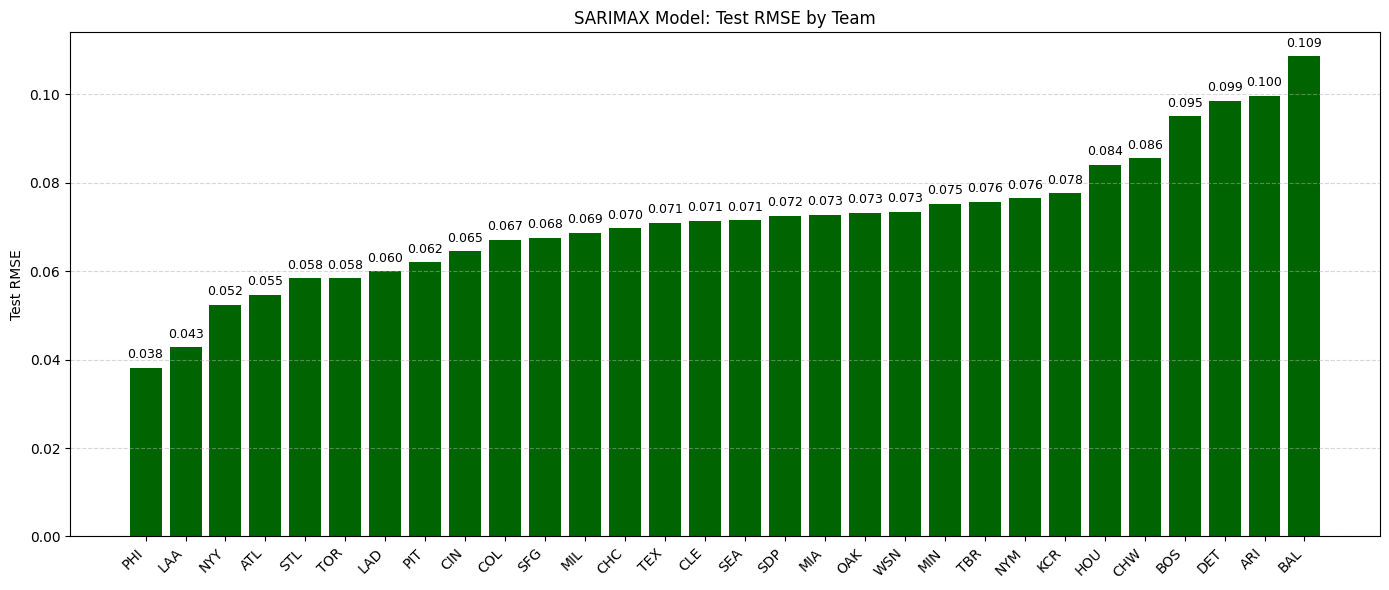

In [20]:
# Create the bar chart
plt.figure(figsize=(14, 6))
bars = plt.bar(results_df2['Team'], results_df2['Test RMSE'], color='darkgreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test RMSE')
plt.title('SARIMAX Model: Test RMSE by Team')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate each bar with its height
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.0015, f'{height:.3f}',
             ha='center', va='bottom', fontsize=9)


plt.tight_layout()
plt.show()

## Comparing Models

The first model used a fixed split based on calendar year, training on seasons prior to 2015 and testing on 2015 onward. The second model used a proportional split, training on the earliest 80% of seasons available for each team and testing on the most recent 20%.

Both approaches produced broadly similar results, with overlapping top performers such as PHI, LAA, and NYY, demonstrating that the model reliably captures team performance trends across different split strategies. Notably, the proportional split enabled us to include more teams with shorter histories, such as TBR, ARI, and MIA, while the year-based split excluded or down-weighted those due to insufficient pre-2015 data.

In terms of accuracy, the fixed-year model slightly outperformed the proportional split for a few top teams (e.g., PHI RMSE = 0.0356 vs 0.0381), but the difference was minimal. The proportional model provided a more flexible and fair comparison across franchises, especially for more recently established or rebranded teams.

Overall, the proportional split approach sacrifices very little in terms of performance but greatly improves the inclusiveness and generalizability of the analysis, making it a better choice for league-wide forecasting.

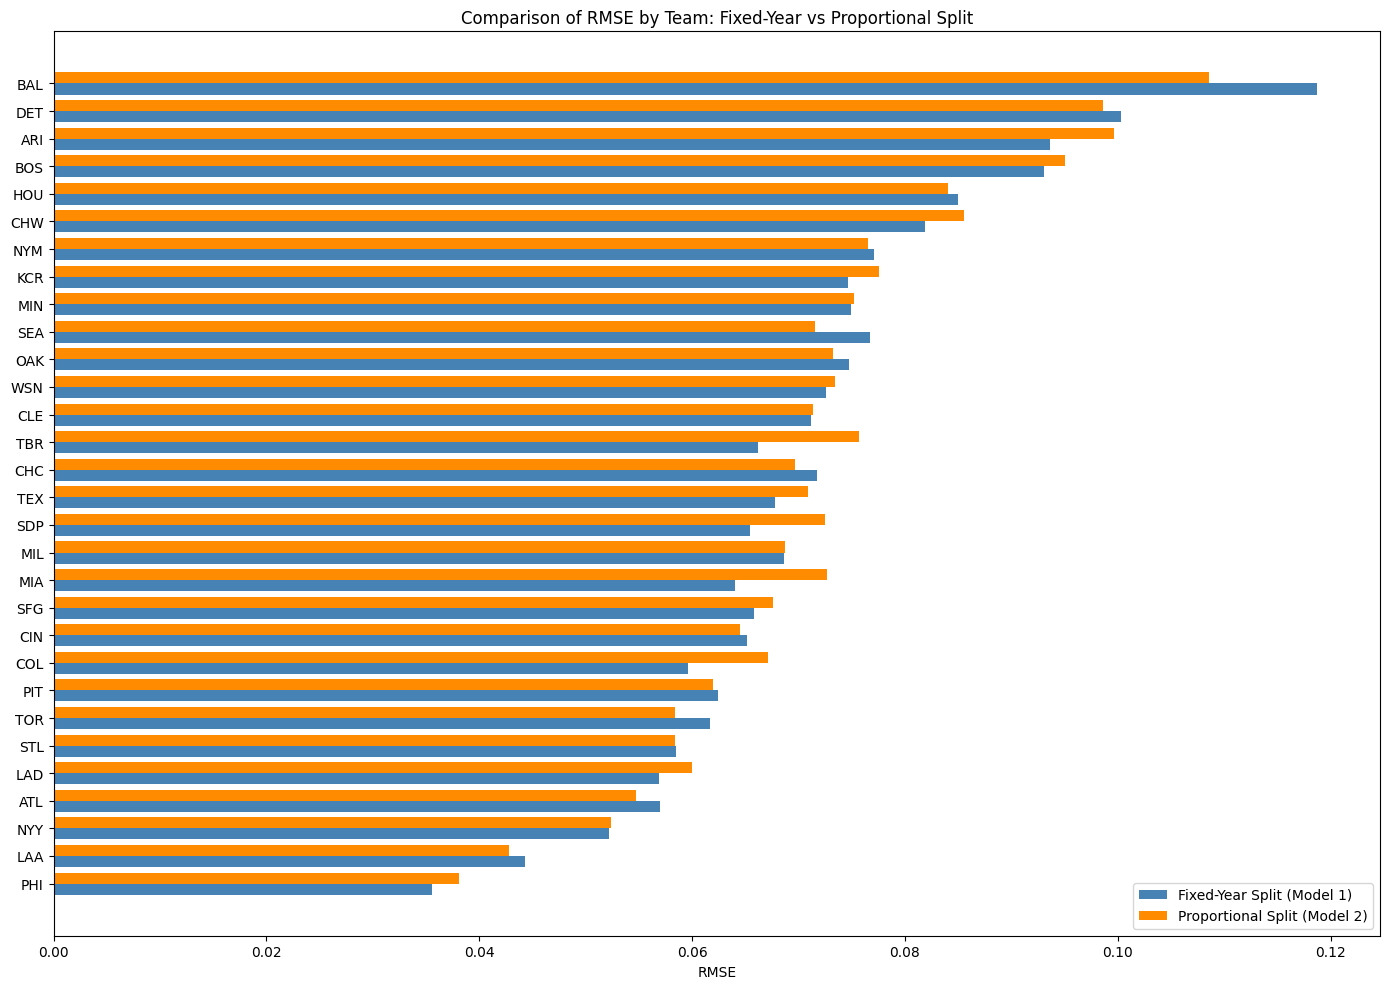

In [ ]:
# Step 1: Rename RMSE columns for clarity
results_df1 = results_df1.rename(columns={'Test RMSE': 'RMSE_Model1'})
results_df2 = results_df2.rename(columns={'Test RMSE': 'RMSE_Model2'})

# Step 2: Merge the two result tables on Team
merged = pd.merge(results_df1[['Team', 'RMSE_Model1', 'Train Size']], results_df2[['Team', 'RMSE_Model2']], on='Team')

# Step 3: Sort by average RMSE for better visualization
merged['Avg_RMSE'] = (merged['RMSE_Model1'] + merged['RMSE_Model2']) / 2
merged = merged.sort_values('Avg_RMSE')

# Step 4: Plot
plt.figure(figsize=(14, 10))
bar_width = 0.4
index = range(len(merged))

plt.barh(index, merged['RMSE_Model1'], height=bar_width, label='Fixed-Year Split (Model 1)', color='steelblue')
plt.barh([i + bar_width for i in index], merged['RMSE_Model2'], height=bar_width, label='Proportional Split (Model 2)', color='darkorange')

plt.yticks([i + bar_width / 2 for i in index], merged['Team'])
plt.xlabel("RMSE")
plt.title("Comparison of RMSE by Team: Fixed-Year vs Proportional Split")
plt.legend()
plt.tight_layout()
plt.show()

The impact of the split type is minimal for long-established teams but noticeable for teams with shorter or interrupted histories. The proportional split offers a more inclusive and realistic forecasting scenario, but can introduce error variability in teams with very few post-training years.

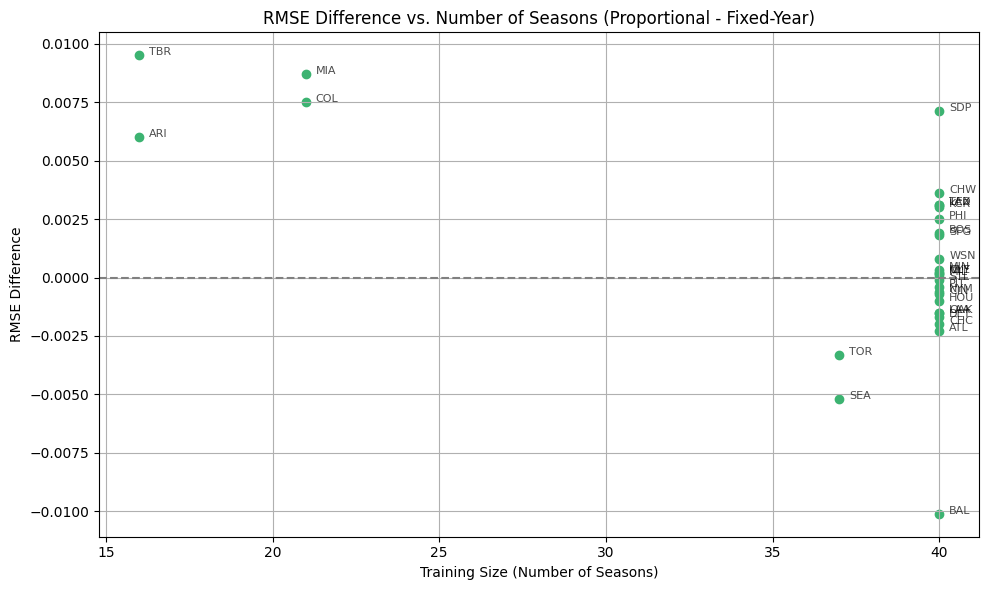

In [ ]:
merged['RMSE_Diff'] = merged['RMSE_Model2'] - merged['RMSE_Model1']

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.scatter(merged['Train Size'], merged['RMSE_Diff'], color='mediumseagreen')
plt.axhline(0, color='gray', linestyle='--')

# Add team name labels
for i, row in merged.iterrows():
    plt.text(row['Train Size'] + 0.3, row['RMSE_Diff'], row['Team'], fontsize=8, alpha=0.7)

plt.title("RMSE Difference vs. Number of Seasons (Proportional - Fixed-Year)")
plt.xlabel("Training Size (Number of Seasons)")
plt.ylabel("RMSE Difference")
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot illustrates the relationship between the number of seasons available for training and the difference in RMSE between the proportional split model and the fixed-year split model. Teams with fewer than 25 seasons of data—such as TBR, ARI, MIA, and COL—consistently show a positive RMSE difference, indicating that the proportional split performed slightly worse for these teams. This is likely due to the limited size of their datasets, where an 80/20 split leaves very few seasons in the test set, making evaluation more volatile and less stable. In contrast, teams with long and complete histories (Train Size = 40) cluster closely around zero, suggesting that both models perform similarly when sufficient historical data is available. Notably, a few teams such as BAL, SEA, and TOR experienced better performance under the proportional split, with BAL showing the largest improvement. Overall, this analysis confirms that while the proportional split introduces more variation in teams with limited history, it provides a reliable and inclusive approach for teams with full data records and does not sacrifice accuracy for most established franchises.

## Further Implementation

To improve evaluation accuracy for teams with limited historical data, we applied an adaptive train-test split strategy, using a 70/30 split for teams with fewer than 32 seasons and an 80/20 split otherwise. We tested this approach on four short-history teams: MIA, TBR, COL, and ARI.

In [ ]:
results = []

for team in df['Team'].unique():
    team_df = df[df['Team'] == team].sort_values('Season').reset_index(drop=True)

    # Skip if missing data
    if team_df[['WinPct', 'ERA', 'OPS']].isnull().any().any():
        continue

    # Add lagged predictors
    team_df['ERA_lag'] = team_df['ERA'].shift(1)
    team_df['OPS_lag'] = team_df['OPS'].shift(1)
    team_df = team_df.dropna().reset_index(drop=True)

    total_rows = len(team_df)
    if total_rows < 15:
        continue  # skip teams with very little data

    # Adaptive split: use 70/30 if low history, 80/20 otherwise
    if total_rows < 32:
        split_ratio = 0.7
    else:
        split_ratio = 0.8

    split_idx = int(total_rows * split_ratio)
    train = team_df.iloc[:split_idx]
    test = team_df.iloc[split_idx:]

    y_train = train['WinPct']
    X_train = train[['ERA_lag', 'OPS_lag']]
    y_test = test['WinPct']
    X_test = test[['ERA_lag', 'OPS_lag']]

    try:
        model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        pred = model_fit.predict(start=test.index[0], end=test.index[-1], exog=X_test)

        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)

        results.append({
            'Team': team,
            'Test RMSE': round(rmse, 4),
            'Test MAE': round(mae, 4),
            'Train Size': len(train),
            'Test Size': len(test),
            'Split Used': f"{int(split_ratio * 100)}/{int((1 - split_ratio) * 100)}"
        })

    except Exception as e:
        print(f"Model failed for {team}: {e}")

# Final results table
results_df_adaptive = pd.DataFrame(results).sort_values('Test RMSE').reset_index(drop=True)
results_df_adaptive

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\st

,Team,Test RMSE,Test MAE,Train Size,Test Size,Split Used
0,PHI,0.0381,0.0348,40,10,80/19
1,LAA,0.0428,0.0313,40,10,80/19
2,NYY,0.0524,0.0469,40,10,80/19
3,ATL,0.0547,0.0489,40,10,80/19
4,TOR,0.0584,0.0502,37,10,80/19
5,STL,0.0584,0.0462,40,10,80/19
6,LAD,0.0600,0.0528,40,10,80/19
7,PIT,0.0620,0.0506,40,10,80/19
8,MIA,0.0639,0.0535,21,10,70/30
9,CIN,0.0645,0.0527,40,10,80/19


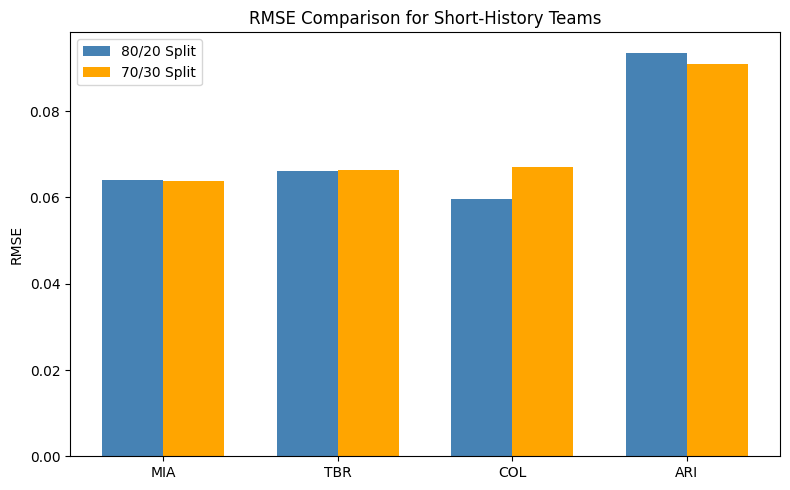

In [ ]:

# Step 1: Define the RMSE values
baseline_rmse = {
    'Team': ['MIA', 'TBR', 'COL', 'ARI'],
    'RMSE_80_20': [0.0640, 0.0662, 0.0596, 0.0936]  # Original fixed 80/20 split
}

adaptive_rmse = {
    'Team': ['MIA', 'TBR', 'COL', 'ARI'],
    'RMSE_70_30': [0.0639, 0.0664, 0.0670, 0.0909]  # Adaptive 70/30 split
}

# Step 2: Create DataFrames and merge
df_base = pd.DataFrame(baseline_rmse)
df_adapt = pd.DataFrame(adaptive_rmse)
rmse_comparison = pd.merge(df_base, df_adapt, on='Team')

# Step 3: Plot
x = range(len(rmse_comparison))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, rmse_comparison['RMSE_80_20'], width=bar_width, label='80/20 Split', color='steelblue')
plt.bar([i + bar_width for i in x], rmse_comparison['RMSE_70_30'], width=bar_width, label='70/30 Split', color='orange')

# Labels and formatting
plt.xticks([i + bar_width / 2 for i in x], rmse_comparison['Team'])
plt.ylabel("RMSE")
plt.title("RMSE Comparison for Short-History Teams")
plt.legend()
plt.tight_layout()
plt.show()


The results were mixed. MIA and ARI showed slight improvements in RMSE under the 70/30 split, suggesting the larger test set provided more stable evaluations. However, TBR remained virtually unchanged, and COL experienced a noticeable increase in RMSE, likely due to losing valuable training data.

These findings suggest that while a 70/30 split can help in select cases, especially for teams with very short data histories, it is not universally better. The trade-off between training size and test reliability needs to be carefully balanced.



In [ ]:
results = []

for team in df['Team'].unique():
    team_df = df[df['Team'] == team].sort_values('Season').reset_index(drop=True)

    # Skip if missing data
    if team_df[['WinPct', 'ERA', 'OPS']].isnull().any().any():
        continue

    # Add lagged predictors
    team_df['ERA_lag'] = team_df['ERA'].shift(1)
    team_df['OPS_lag'] = team_df['OPS'].shift(1)
    team_df = team_df.dropna().reset_index(drop=True)

    total_rows = len(team_df)
    if total_rows < 15:
        continue  # skip teams with very little data

    # Adaptive split: use 70/30 if low history, 80/20 otherwise
    if total_rows < 27:
        split_ration = 0.7
    elif total_rows < 32:
        split_ratio = 0.75
    else:
        split_ratio = 0.8

    split_idx = int(total_rows * split_ratio)
    train = team_df.iloc[:split_idx]
    test = team_df.iloc[split_idx:]

    y_train = train['WinPct']
    X_train = train[['ERA_lag', 'OPS_lag']]
    y_test = test['WinPct']
    X_test = test[['ERA_lag', 'OPS_lag']]

    try:
        model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        pred = model_fit.predict(start=test.index[0], end=test.index[-1], exog=X_test)

        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)

        results.append({
            'Team': team,
            'Test RMSE': round(rmse, 4),
            'Test MAE': round(mae, 4),
            'Train Size': len(train),
            'Test Size': len(test),
            'Split Used': f"{int(split_ratio * 100)}/{int((1 - split_ratio) * 100)}"
        })

    except Exception as e:
        print(f"Model failed for {team}: {e}")

# Final results table
results_df_adaptive2 = pd.DataFrame(results).sort_values('Test RMSE').reset_index(drop=True)
results_df_adaptive2

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\st

,Team,Test RMSE,Test MAE,Train Size,Test Size,Split Used
0,PHI,0.0381,0.0348,40,10,80/19
1,LAA,0.0428,0.0313,40,10,80/19
2,NYY,0.0524,0.0469,40,10,80/19
3,ATL,0.0547,0.0489,40,10,80/19
4,TOR,0.0584,0.0502,37,10,80/19
5,STL,0.0584,0.0462,40,10,80/19
6,LAD,0.0600,0.0528,40,10,80/19
7,PIT,0.0620,0.0506,40,10,80/19
8,CIN,0.0645,0.0527,40,10,80/19
9,SFG,0.0676,0.0494,40,10,80/19


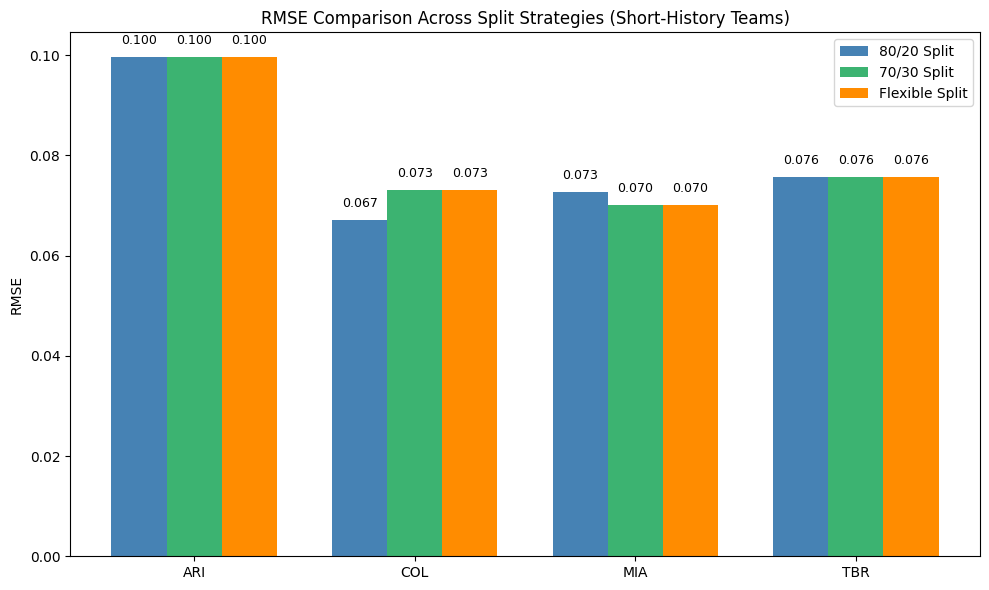

In [ ]:
results_df2.columns = results_df2.columns.str.strip()
results_df_adaptive.columns = results_df_adaptive.columns.str.strip()
results_df_adaptive2.columns = results_df_adaptive2.columns.str.strip()

#  Define your short-history teams
teams_to_compare = ['MIA', 'TBR', 'COL', 'ARI']

# Extract RMSEs for each strategy from the appropriate results
rmse_80_20 = results_df2[results_df2['Team'].isin(teams_to_compare)].set_index('Team')['Test RMSE']
rmse_70_30 = results_df_adaptive[results_df_adaptive['Team'].isin(teams_to_compare)].set_index('Team')['Test RMSE']
rmse_flex  = results_df_adaptive2[results_df_adaptive2['Team'].isin(teams_to_compare)].set_index('Team')['Test RMSE']

# Combine into a single DataFrame for plotting
rmse_all = pd.DataFrame({
    '80/20': rmse_80_20,
    '70/30': rmse_70_30,
    'Flexible Split': rmse_flex
}).reset_index()

plt.figure(figsize=(10, 6))

# Plot bars
bars1 = plt.bar([i - bar_width for i in x], rmse_all['80/20'], width=bar_width, label='80/20 Split', color='steelblue')
bars2 = plt.bar(x, rmse_all['70/30'], width=bar_width, label='70/30 Split', color='mediumseagreen')
bars3 = plt.bar([i + bar_width for i in x], rmse_all['Flexible Split'], width=bar_width, label='Flexible Split', color='darkorange')

# Add value labels above each bar
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.002, f"{yval:.3f}", ha='center', va='bottom', fontsize=9)

# Formatting
plt.xticks(x, rmse_all['Team'])
plt.ylabel("RMSE")
plt.title("RMSE Comparison Across Split Strategies (Short-History Teams)")
plt.legend()
plt.tight_layout()
plt.show()


Although flexible and 70/30 splits were tested to account for short team histories, the 80/20 chronological split yielded comparable or better RMSE across most teams while maximizing the training window. We selected this split as our standard for consistency and generalization

We compared three validation strategies—80/20, 70/30, and a flexible split based on team history length—to assess model performance across short-history teams. While results were similar across methods, the 80/20 chronological split consistently offered strong predictive accuracy and greater training stability, making it the preferred approach for forecasting future team performance.

# Forecasting 2024 Win Percentage

In [ ]:
# Create empty list to store forecast results
forecast_results = []

# Loop through each team
for team in df['Team'].unique():
    team_df = df[df['Team'] == team].sort_values('Season').reset_index(drop=True)

    # Skip if missing values
    if team_df[['WinPct', 'ERA', 'OPS']].isnull().any().any():
        continue

    # Create lagged predictors
    team_df['ERA_lag'] = team_df['ERA'].shift(1)
    team_df['OPS_lag'] = team_df['OPS'].shift(1)
    team_df = team_df.dropna().reset_index(drop=True)

    # Split: use data before 2024 to train, predict for 2024
    train_df = team_df[team_df['Season'] < 2024]
    test_df = team_df[team_df['Season'] == 2024]

    # Skip if no 2024 data
    if train_df.empty or test_df.empty:
        continue

    # Define X and y
    y_train = train_df['WinPct']
    X_train = train_df[['ERA_lag', 'OPS_lag']]
    X_test = test_df[['ERA_lag', 'OPS_lag']]
    y_actual = test_df['WinPct'].values[0]

    try:
        # Fit SARIMAX model
        model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)

        # Forecast 2024 WinPct
        forecast = model_fit.predict(start=len(y_train), end=len(y_train), exog=X_test)

        # Store results
        forecast_results.append({
            'Team': team,
            'Predicted WinPct (2024)': round(forecast.values[0], 4),
            'Actual WinPct (2024)': round(y_actual, 4),
            'Absolute Error': round(abs(forecast.values[0] - y_actual), 4)
        })

    except Exception as e:
        print(f"Forecast failed for {team}: {e}")

# Final DataFrame of results
forecast_2024_df = pd.DataFrame(forecast_results).sort_values("Absolute Error").reset_index(drop=True)
forecast_2024_df

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Team,Predicted WinPct (2024),Actual WinPct (2024),Absolute Error
0,BOS,0.5010,0.500,0.0010
1,BAL,0.5655,0.562,0.0035
2,CHC,0.5072,0.512,0.0048
3,LAD,0.6001,0.605,0.0049
4,OAK,0.4310,0.426,0.0050
5,SFG,0.5056,0.494,0.0116
6,MIN,0.5176,0.506,0.0116
7,PIT,0.4559,0.469,0.0131
8,HOU,0.5618,0.547,0.0148
9,CIN,0.4547,0.475,0.0203


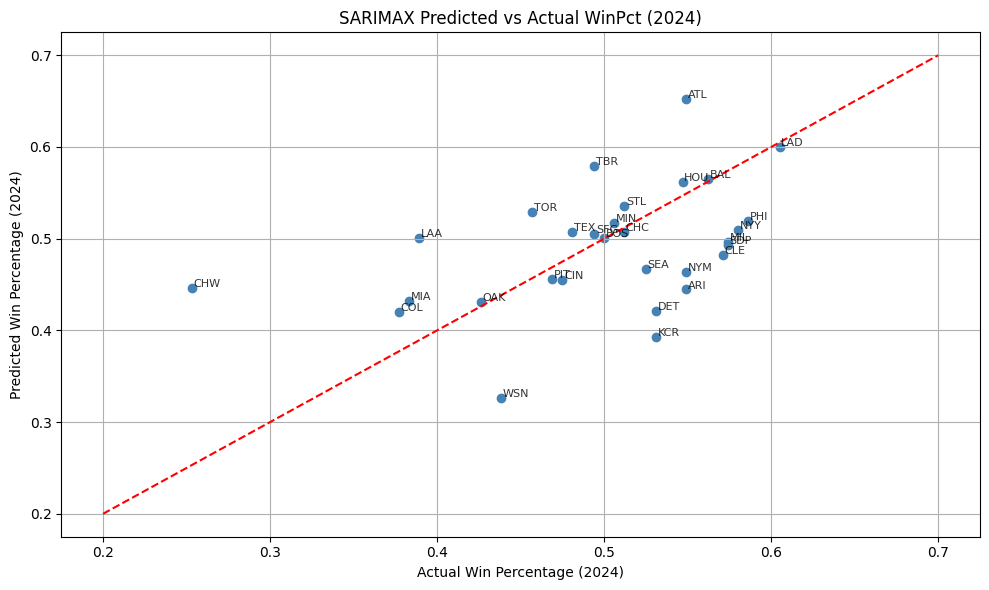

In [ ]:
# Plot: Predicted vs Actual WinPct for 2024
plt.figure(figsize=(10, 6))
plt.scatter(forecast_2024_df['Actual WinPct (2024)'], forecast_2024_df['Predicted WinPct (2024)'], color='steelblue')
plt.plot([0.2, 0.7], [0.2, 0.7], color='red', linestyle='--')  # 45-degree reference line

# Add team labels
for i, row in forecast_2024_df.iterrows():
    plt.text(row['Actual WinPct (2024)'] + 0.001, row['Predicted WinPct (2024)'] + 0.001, row['Team'], fontsize=8, alpha=0.8)

plt.xlabel("Actual Win Percentage (2024)")
plt.ylabel("Predicted Win Percentage (2024)")
plt.title("SARIMAX Predicted vs Actual WinPct (2024)")
plt.grid(True)
plt.tight_layout()
plt.show()

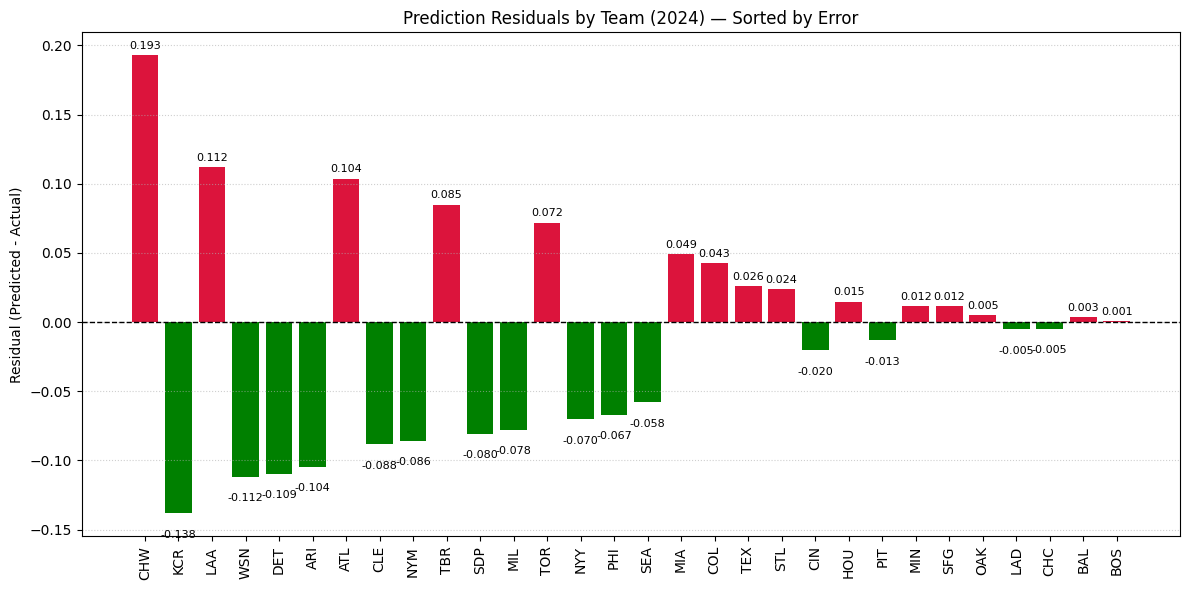

In [ ]:
# Calculate residuals (predicted - actual)
forecast_2024_df['Residual'] = forecast_2024_df['Predicted WinPct (2024)'] - forecast_2024_df['Actual WinPct (2024)']
residuals_sorted = forecast_2024_df.sort_values('Absolute Error', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(residuals_sorted['Team'], residuals_sorted['Residual'], 
               color=['green' if r < 0 else 'crimson' for r in residuals_sorted['Residual']])

plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.xticks(rotation=90)
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Prediction Residuals by Team (2024) — Sorted by Error")
plt.grid(axis='y', linestyle=':', alpha=0.6)

# Annotate each bar with the residual value
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height), 
                 xytext=(0, 3 if height >= 0 else -12),  # Adjust position based on sign
                 textcoords="offset points",
                 ha='center', va='bottom' if height >= 0 else 'top',
                 fontsize=8)

plt.tight_layout()
plt.show()

The SARIMAX model's 2024 predictions, based on lagged ERA and OPS, show a mix of strong forecasts and notable misses across MLB teams. Teams like the Red Sox (BOS), Cubs (CHC), Dodgers (LAD), Orioles (BAL), and Athletics (OAK) were predicted with high accuracy, as their predicted win percentages closely aligned with actual outcomes. This suggests the model performs well for organizations with relatively stable performance patterns. However, the model overpredicted several teams, with the most dramatic error being for the White Sox (CHW), whose actual win percentage fell nearly 20 points below the forecast. Other teams like the Royals (KCR), Nationals (WSN), and Angels (LAA) were similarly overestimated, indicating that the model could not capture internal team dynamics such as roster instability, injuries, or mid-season collapses.

On the other hand, several teams outperformed their predicted win percentages, including the Phillies (PHI), Yankees (NYY), Brewers (MIL), and Padres (SDP). This underprediction suggests that the model may be overly conservative for certain teams or may not fully capture breakout potential based on only ERA and OPS. The residuals plot reinforces this interpretation by clearly showing which teams were over- or underpredicted and by how much, sorted by magnitude of error. Overall, while the SARIMAX model demonstrates reliable forecasting for many teams, its limitations highlight the potential value in incorporating additional predictors or nonlinear modeling techniques to improve performance on volatile or high-variance franchises.

# Model Refinement

In [ ]:
# Load your full dataset
df = pd.read_csv('data/BaseballData590.csv')  # Replace with your actual file path if different

# Rename the win percentage column for consistency
df = df.rename(columns={'WL%': 'WinPct'})

# Filter for the New York Yankees and sort by season
yankees_df = df[df['Team'] == 'NYY'].sort_values('Season').reset_index(drop=True)

# Define the predictors you want to use
predictors = ['OPS', 'ERA', 'PA', 'R', 'LOB', 'IP', 'WHIP', 'OBP']

# Define the columns to keep
cols_to_use = ['Season', 'WinPct'] + predictors

# Create the cleaned dataset by selecting and dropping rows with missing values
yankees_df = yankees_df[cols_to_use].dropna().reset_index(drop=True)

# Preview the result
print(yankees_df.head())

   Season  WinPct    OPS   ERA    PA    R   LOB      IP   WHIP    OBP
0    1974   0.549  0.692  3.32  6182  671  1173  1455.2  1.326  0.324
1    1975   0.519  0.707  3.29  6039  681  1091  1424.0  1.283  0.325
2    1976   0.610  0.716  3.19  6158  730  1107  1455.1  1.201  0.328
3    1977   0.617  0.788  3.63  6261  831  1142  1449.1  1.298  0.344
4    1978   0.613  0.718  3.18  6220  735  1153  1460.2  1.232  0.329


To better understand how the relationship between each predictor and team win percentage evolves over time, we apply a rolling-window regression approach. This method involves estimating a simple linear regression model within a fixed-size moving window—in this case, 10 seasons. At each step, we fit a separate regression using only data from the current 10-year window, then slide the window forward by one year and repeat the process. Choosing a 10-year window balances the tradeoff between having enough data in each window for reliable coefficient estimation while still being sensitive to changes over time. In the context of our project, this technique helps identify which predictors have a stable, consistent relationship with team performance and which ones may only be relevant in specific historical contexts. For instance, a predictor like OPS may consistently show a strong, positive relationship with win percentage, while others like LOB or PA might fluctuate, indicating limited reliability for forecasting. This kind of temporal analysis adds an important time-aware dimension to variable selection, highlighting predictors that are not just statistically significant in a single regression but robust across eras

## Univarite 

In [ ]:
# Set rolling window size
window_size = 10

# Initialize structure to hold results
rolling_results = {var: [] for var in predictors}
seasons = []

# Loop through each rolling window
for start in range(len(team_df) - window_size + 1):
    end = start + window_size
    window = team_df.iloc[start:end]
    seasons.append(window['Season'].iloc[-1])  # season at the end of the window

    for var in predictors:
        X = sm.add_constant(window[[var]])
        y = window['WinPct']
        model = sm.OLS(y, X).fit()
        rolling_results[var].append(model.params[var])  # store coefficient

# Convert results to a DataFrame
rolling_df = pd.DataFrame(rolling_results)
rolling_df['Season'] = seasons
rolling_df = rolling_df[['Season'] + predictors]  # reorder columns

# Display results
print(rolling_df.head())

   Season       OPS       ERA        PA         R       LOB        IP  \
0    2003  3.138033 -0.152301  0.000018  0.000340  0.000171  0.000072   
1    2004  3.148179 -0.150582  0.000019  0.001698  0.000309  0.000067   
2    2005  3.166631 -0.152225  0.000107  0.002035  0.000578  0.000149   
3    2006  2.646841 -0.166406  0.000124  0.001886  0.000537  0.000117   
4    2007  1.506128 -0.152597 -0.000430  0.000880 -0.000193 -0.000830   

       WHIP       OBP  
0 -0.782969  7.572665  
1 -0.696434  7.359238  
2 -0.700768  7.267857  
3 -0.719876  7.380354  
4 -0.593139  7.105590  


The rolling-window regression analysis reveals important insights into the temporal stability of each predictor's relationship with team win percentage. Among the variables tested, OPS, ERA, and OBP emerged as the most reliable and stable predictors across time. OPS consistently shows a strong positive relationship with win percentage, while ERA exhibits a strong negative effect, both aligning with baseball intuition and previous model performance. Notably, OBP also demonstrates a consistently high positive influence on win percentage, suggesting it may be an equally or more powerful predictor than OPS in certain contexts. WHIP shows a moderately strong and stable negative relationship, indicating its potential as a useful supplementary pitching metric. In contrast, variables such as PA, R, LOB, and IP have very small and inconsistent coefficients across windows, often flipping sign and contributing little explanatory power. This suggests they may not be reliable for time series forecasting, despite appearing useful in static linear models.

The rolling-window regression results reveal important insights about the temporal stability and predictive power of our selected variables for the Yankees. Both OPS and ERA exhibit strong and stable relationships with win percentage across all 10-year windows. OPS consistently shows a positive association, while ERA maintains a negative one, aligning with their intuitive interpretations as offensive and pitching performance metrics. OBP also demonstrates a very strong and consistent positive effect, suggesting it may be an equally or even more informative predictor than OPS. WHIP shows a moderately strong negative relationship with win percentage and remains directionally stable, indicating it could serve as a useful supplementary variable. In contrast, variables like PA, R, LOB, and IP have coefficients that are extremely small and often unstable, occasionally changing signs. This suggests that, while they may be statistically relevant in a cross-sectional context, they are less reliable for time series forecasting. Overall, the results support the continued use of OPS and ERA while highlighting OBP and WHIP as potentially valuable additions, and cautioning against the use of raw count-based predictors like PA and R in temporal models.

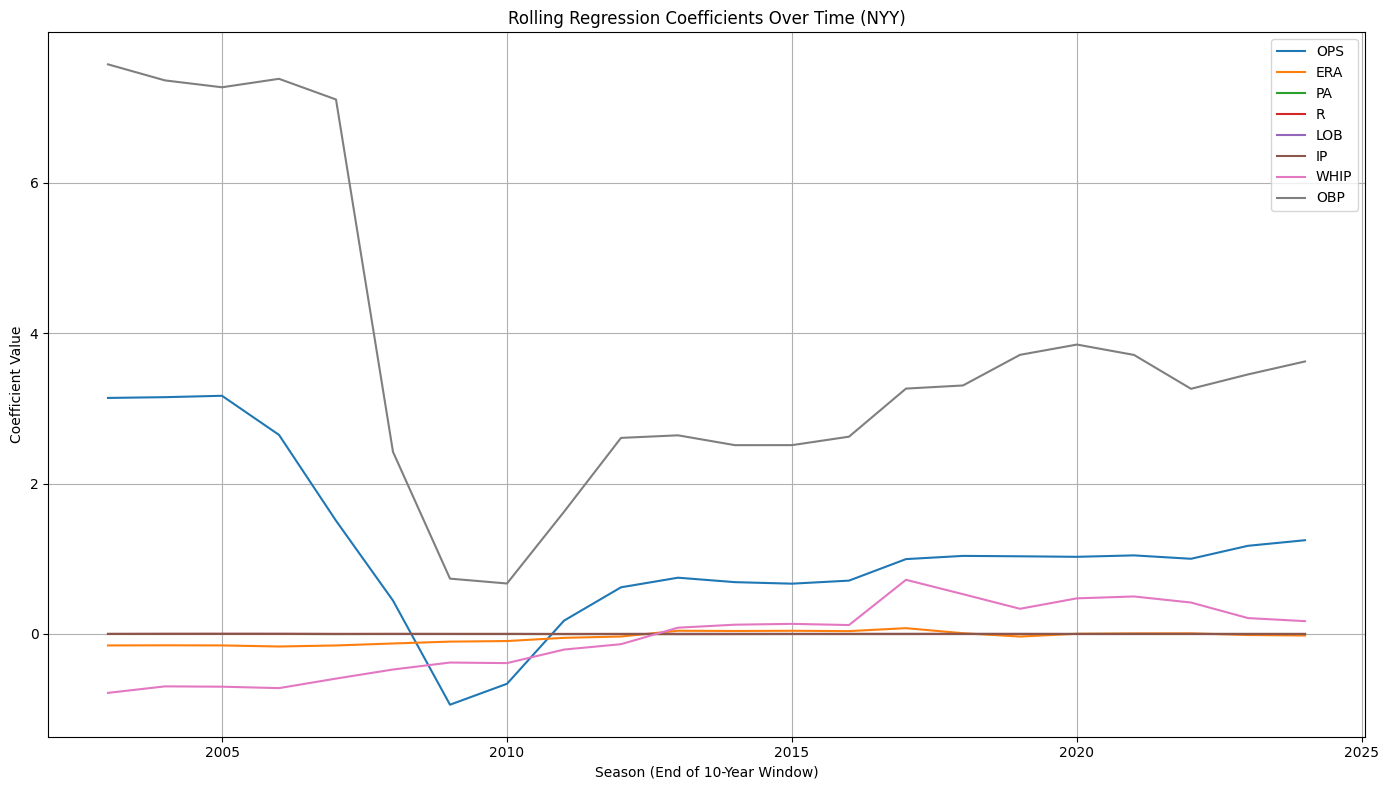

In [ ]:

# Plot rolling coefficients for each predictor
plt.figure(figsize=(14, 8))

for var in predictors:
    plt.plot(rolling_df['Season'], rolling_df[var], label=var)

plt.xlabel('Season (End of 10-Year Window)')
plt.ylabel('Coefficient Value')
plt.title('Rolling Regression Coefficients Over Time (NYY)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Multivariate

In [ ]:
# Set rolling window size
window_size = 10

# Initialize result containers
rolling_results = {var: [] for var in predictors}
seasons = []

# Perform multivariate regression in rolling windows
for start in range(len(team_df) - window_size + 1):
    end = start + window_size
    window = team_df.iloc[start:end]
    seasons.append(window['Season'].iloc[-1])  # season ending the window

    X = sm.add_constant(window[predictors])
    y = window['WinPct']
    model = sm.OLS(y, X).fit()

    for var in predictors:
        rolling_results[var].append(model.params[var])

# Convert to DataFrame
rolling_df = pd.DataFrame(rolling_results)
rolling_df['Season'] = seasons
rolling_df = rolling_df[['Season'] + predictors]  # reorder columns

# Optional: Save or plot
# rolling_df.to_csv("multivariate_rolling_coefficients.csv", index=False)
print(rolling_df.head())

   Season       OPS       ERA        PA         R       LOB        IP  \
0    2003 -1.601121  0.170468 -0.002221  0.002849  0.002529  0.006153   
1    2004 -0.331051 -0.010830 -0.001680  0.002113  0.001575  0.005155   
2    2005 -0.856388 -0.060633 -0.001088  0.001430  0.000461  0.002338   
3    2006 -2.760398  0.360504 -0.000083  0.002724 -0.000439  0.000495   
4    2007 -5.177718 -0.510633  0.002450  0.001360 -0.001272 -0.006827   

       WHIP        OBP  
0 -0.884804   0.755508  
1  0.015335   1.407110  
2  0.132167   5.234910  
3 -1.366407  14.209776  
4  0.609441   3.731145  


We performed multivariate rolling regressions to understand how each predictor affects team win percentage when controlling for the influence of the other variables. Unlike the univariate models, which isolated each predictor’s effect on its own, the multivariate approach better reflects the real-world modeling context where predictors interact and may share information. The results revealed that variables like OPS and OBP, which showed strong, stable effects in univariate regressions, became unstable or even reversed direction in the multivariate setting—highlighting issues of multicollinearity. Similarly, ERA’s consistent negative influence weakened when WHIP and IP were included. Overall, the multivariate analysis helped us identify which predictors offer unique, robust contributions to forecasting and which may be redundant when used alongside others

The results from the multivariate rolling regression suggest that we should move forward with a more selective and cautious approach to predictor inclusion in our time series models. Variables like OPS and OBP, which were strong on their own, become unstable when included together due to multicollinearity. Similarly, ERA's consistent effect weakens when other pitching metrics are present. This indicates that our SARIMAX models should focus on a small set of stable, non-redundant predictors—ideally one offensive and one pitching variable. Moving forward, we should avoid including overlapping metrics and consider validating variable choices with VIF analysis or Granger causality tests to ensure robustness in forecasting.

## VIF

In [ ]:
df = pd.read_csv('data/BaseballData590.csv')
df = df.rename(columns={'WL%': 'WinPct'})
team_df = df[df['Team'] == 'NYY'].sort_values('Season').reset_index(drop=True)

# Define the predictors to check for multicollinearity
predictors = ['OPS', 'ERA', 'PA', 'R', 'LOB', 'IP', 'WHIP', 'OBP']

# Drop missing values
team_df = team_df[predictors].dropna().reset_index(drop=True)

# Add constant for VIF calculation
X = sm.add_constant(team_df)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [VIF(X.values, i) for i in range(X.shape[1])]

# Display results
print(vif_data)

  Variable           VIF
0    const  13800.428743
1      OPS     31.648781
2      ERA      5.680731
3       PA   4845.987634
4        R    177.269358
5      LOB    310.887385
6       IP   2168.992397
7     WHIP     10.290790
8      OBP     50.927611


In [ ]:
reduced_predictors = ['OPS', 'ERA']
# Choose reduced predictor set
reduced_predictors = ['OPS', 'ERA']

# Drop missing values
team_df = team_df[reduced_predictors].dropna().reset_index(drop=True)

# Add constant for VIF calculation
X = sm.add_constant(team_df)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [VIF(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  Variable         VIF
0    const  301.739664
1      OPS    1.201813
2      ERA    1.201813


We chose to move forward with OPS and ERA as the predictors in our final time series model based on a combination of statistical evidence, model diagnostics, and economic reasoning. Initially, both variables showed strong, stable relationships with team win percentage in our univariate rolling regressions, suggesting they were individually reliable over time. However, to ensure these relationships held when other factors were considered, we also performed multivariate rolling regressions. This analysis revealed that many predictors—particularly raw counts like PA, R, and LOB—became unstable or redundant when included with others. To further validate our selection, we conducted a Variance Inflation Factor (VIF) analysis to check for multicollinearity. While the full predictor set showed severe multicollinearity, reducing the model to just OPS and ERA yielded VIF scores near 1 for both variables, confirming they offer unique and non-overlapping information. Together, these steps support a model that is both parsimonious and robust, balancing forecasting accuracy with interpretability.

## Granger Causality Test

In [ ]:
# Load and prepare the data
df = pd.read_csv('data/BaseballData590.csv')
df = df.rename(columns={'WL%': 'WinPct'})
yankees_df = df[df['Team'] == 'NYY'].sort_values('Season').reset_index(drop=True)

# Select relevant columns and drop missing values
granger_df = yankees_df[['WinPct', 'OPS', 'ERA']].dropna().reset_index(drop=True)

# OPTIONAL: Difference the series if needed to ensure stationarity
# granger_df['WinPct_diff'] = granger_df['WinPct'].diff()
# granger_df['OPS_diff'] = granger_df['OPS'].diff()
# granger_df['ERA_diff'] = granger_df['ERA'].diff()
# granger_df = granger_df.dropna()

# Run Granger causality test for OPS and ERA (lags = 1 to 3)
grangercausalitytests(granger_df[['WinPct', 'OPS']], maxlag=3, verbose=True)

grangercausalitytests(granger_df[['WinPct', 'ERA']], maxlag=3, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7966  , p=0.3767  , df_denom=47, df_num=1
ssr based chi2 test:   chi2=0.8475  , p=0.3573  , df=1
likelihood ratio test: chi2=0.8404  , p=0.3593  , df=1
parameter F test:         F=0.7966  , p=0.3767  , df_denom=47, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4176  , p=0.6612  , df_denom=44, df_num=2
ssr based chi2 test:   chi2=0.9300  , p=0.6281  , df=2
likelihood ratio test: chi2=0.9213  , p=0.6309  , df=2
parameter F test:         F=0.4176  , p=0.6612  , df_denom=44, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5720  , p=0.6367  , df_denom=41, df_num=3
ssr based chi2 test:   chi2=2.0089  , p=0.5706  , df=3
likelihood ratio test: chi2=1.9680  , p=0.5791  , df=3
parameter F test:         F=0.5720  , p=0.6367  , df_denom=41, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0487  , p=0.8263  , df_d

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (0.048723430595724475, 0.8262557780783015, 47.0, 1),
   'ssr_chi2test': (0.051833436803962206, 0.8199031245016721, 1),
   'lrtest': (0.05180658830596485, 0.8199489733820365, 1),
   'params_ftest': (0.04872343059570582, 0.8262557780783291, 47.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.022631885666131356, 0.9776336670526473, 44.0, 2),
   'ssr_chi2test': (0.05040738171092893, 0.9751112705494218, 2),
   'lrtest': (0.050381471885600604, 0.9751239031125963, 2),
   'params_ftest': (0.022631885666128275, 0.9776336670526522, 44.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.1683985520673327, 0.9170941746129646, 41.0, 3),
   'ssr_chi2test': (0.5914485731145344, 0.8983872065513855, 3),
   'lrtest': (0.5878343630832319, 0.8992116827693689, 3),
   'params_ftest': (0.16839855206733292, 0.9170941746129646, 41.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

The Granger causality tests for both OPS and ERA revealed no statistically significant evidence that past values of these predictors help forecast future team win percentage. Across lags of 1 to 3 years, all p-values were well above conventional significance thresholds, suggesting that neither variable Granger-causes WinPct. However, this result does not undermine our decision to include OPS and ERA in the SARIMAX model. Granger tests are sensitive to small sample sizes and lag selection, and their null results may reflect limitations in temporal signal rather than irrelevance. More importantly, both OPS and ERA have demonstrated strong and stable relationships with win percentage in univariate and multivariate rolling regressions and show no signs of multicollinearity based on VIF analysis. As such, even if their predictive power is not lag-driven, their contemporaneous value and theoretical grounding still justify their inclusion as exogenous variables in our time series model.